# Retail Data Wrangling and Analytics

In [2]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load Data from PSQL into DataFrame

**Setup Docker Containers**

![](https://i.imgur.com/VQrBVBk.jpg)

```
#make sure you have both Jupyter and PSQL docker container running
docker ps

#Attach a bridge network to both containers so they can communicate with each other
docker network create jarvis-net
#this command works on running containers
docker network connect jarvis-net jarvis-jupyter
docker network connect jarvis-net jarvis-psql

#verify both containers are attached to the jarvis-net
docker network inspect trading-net

#Note: instead of using `localhost`, you should use container names as hostnames.
```

**Data Preperation**

- Use [pandas.read_sql](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) api to load the PSQL retail table into a Pandas DataFrame

![](https://i.imgur.com/AmkAP63.jpg)

- Get familair with the transaction date with `df.head()`, `df.sample(10)`, `df.info()`, `df.describe()`, etc..



In [3]:
#install psql "driver"
!pip3 install psycopg2-binary


In [4]:
DB_HOST = "localhost"
DB_USER =  "postgres"
DB_PORT = 5432
DB_NAME = "retail"
DB_PASS = "password"
import psycopg2
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)
retail_df = pd.read_sql_query("select * from retail", conn) 
conn.close()

In [5]:
print(retail_df.head())
retail_df.info()
retail_df.describe()

  invoice_no stock_code                       description  quantity  \
0     573159      22983               CARD BILLBOARD FONT        12   
1     573159      23230              WRAP ALPHABET DESIGN        25   
2     573159      22187  GREEN CHRISTMAS TREE CARD HOLDER         4   
3     573159      84946      ANTIQUE SILVER T-LIGHT GLASS        12   
4     573160      23110           PARISIENNE KEY CABINET          2   

         invoice_date  unit_price  customer_id         country  
0 2011-10-28 08:58:00        0.42      16648.0  United Kingdom  
1 2011-10-28 08:58:00        0.42      16648.0  United Kingdom  
2 2011-10-28 08:58:00        4.25      16648.0  United Kingdom  
3 2011-10-28 08:58:00        1.25      16648.0  United Kingdom  
4 2011-10-28 08:58:00        5.75      14359.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        

,quantity,unit_price,customer_id
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, you will need to use Pandas to clean up the data before doing any analytics. In addition, unlike the PSQL scheme, CSV files do not have data types associated. Therefore, you will need to cast/convert certain columns into correct data types (e.g. DateTime, numbers, etc..)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [6]:
#retail_df = pd.read_csv
#retail_df.head()

# Total Invoice Amount Distribution

Minimum: 0.19
Mean: 523.3
Median: 304.31
Mode: 15.0
Maximum: 168469.59
----------------


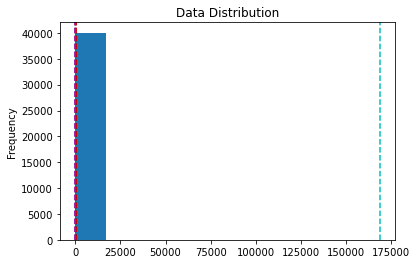

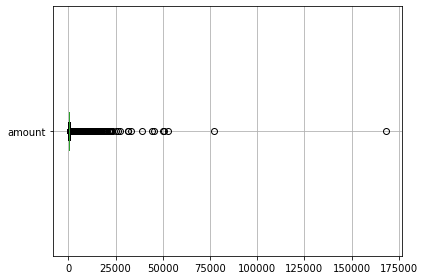

In [7]:
import psycopg2
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)
invoice_amount = pd.read_sql_query('SELECT SUM(unit_price*quantity) as Amount FROM retail'
' GROUP BY invoice_no HAVING SUM(unit_price*quantity) > 0', conn)

# Descriptive statistics
def show_distribution(dataset):

    minimum = dataset.min()['amount']
    mean = dataset.mean()['amount']
    median = dataset.median()['amount']
    mode = dataset.mode()['amount'][0]
    maximum = dataset.max()['amount']

    print("Minimum:", minimum.round(2))
    print("Mean:", mean.round(2))
    print("Median:", median.round(2))
    print("Mode:", mode.round(2))
    print("Maximum:", maximum.round(2))
    print("----------------")

    # Histogram with descriptive statistics showing
    hist = dataset.plot.hist(by='Amount', bins=10)
    xcoords = [mean, median, minimum, mode, maximum]
    colors=['k','r','g','m', 'c']

    for xc,c in zip(xcoords,colors):
        plt.axvline(x=xc, c=c, linestyle='--')

    plt.title("Data Distribution")
    plt.legend().remove()
    fig1, ax1 = plt.subplots()
    plt.tight_layout()

    # Boxplot 
    boxplot = dataset.boxplot(vert=False)
    plt.tight_layout()
    
    plt.show()
show_distribution(invoice_amount)    
conn.close()

Minimum: 0.19
Mean: 271.68
Median: 256.23
Mode: 15.0
Maximum: 724.25
----------------


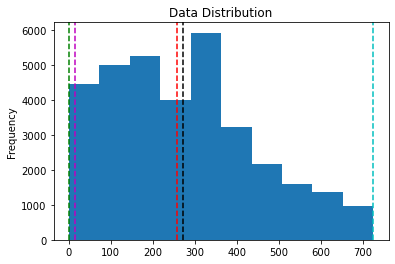

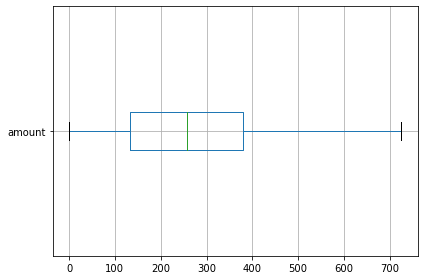

In [8]:
remove_outliers = invoice_amount[invoice_amount['amount'] < np.percentile(invoice_amount['amount'],85)]
show_distribution(remove_outliers)

# Monthly Placed and Canceled Orders

<AxesSubplot:xlabel='invoiceyearmonth'>

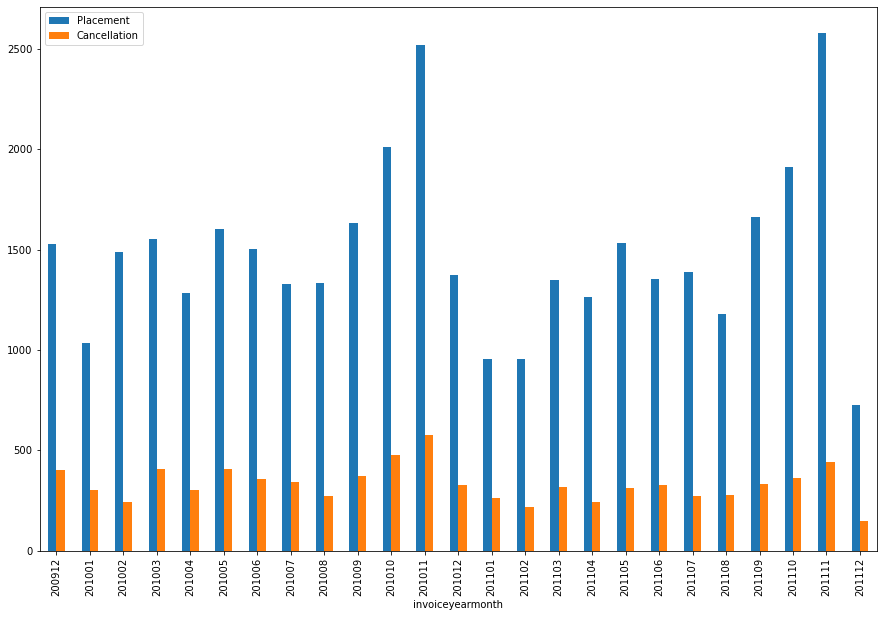

In [9]:
import psycopg2
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)
canceled_orders = pd.read_sql_query("SELECT to_char(invoice_date, 'YYYYMM') AS InvoiceYearMonth, "
"invoice_no "
"FROM retail "
"GROUP BY to_char(invoice_date, 'YYYYMM'), invoice_no "
"HAVING invoice_no LIKE 'C%';",conn)

total_orders = pd.read_sql_query("SELECT to_char(invoice_date, 'YYYYMM') AS InvoiceYearMonth, "
"invoice_no "
"FROM retail "
"GROUP BY to_char(invoice_date, 'YYYYMM'), invoice_no;", conn)

monthly_canceled_orders = canceled_orders.groupby(by=['invoiceyearmonth']).count()
df_canceled = monthly_canceled_orders.rename(columns={'invoice_no':'Cancellation'})
monthly_orders_total= total_orders.groupby(by=['invoiceyearmonth']).count()
df_total = monthly_orders_total.rename(columns={'invoice_no':'Total'})

df = pd.merge(df_total, df_canceled, on="invoiceyearmonth", how="left")

df['Placement'] = df.Total - 2*df.Cancellation
df.reset_index().plot(x='invoiceyearmonth', y=['Placement', 'Cancellation'], kind='bar', figsize=(15,10))

# Monthly Sales

In [10]:
# Format year, calculate sales, new df with monthly sales
retail_df['Month'] = retail_df['invoice_date'].dt.strftime('%Y%m')
retail_df['Sales'] = retail_df.quantity * retail_df.unit_price
sales_df = retail_df[['Month', 'Sales']].copy()
sales_month = sales_df.groupby(by=['Month']).sum()

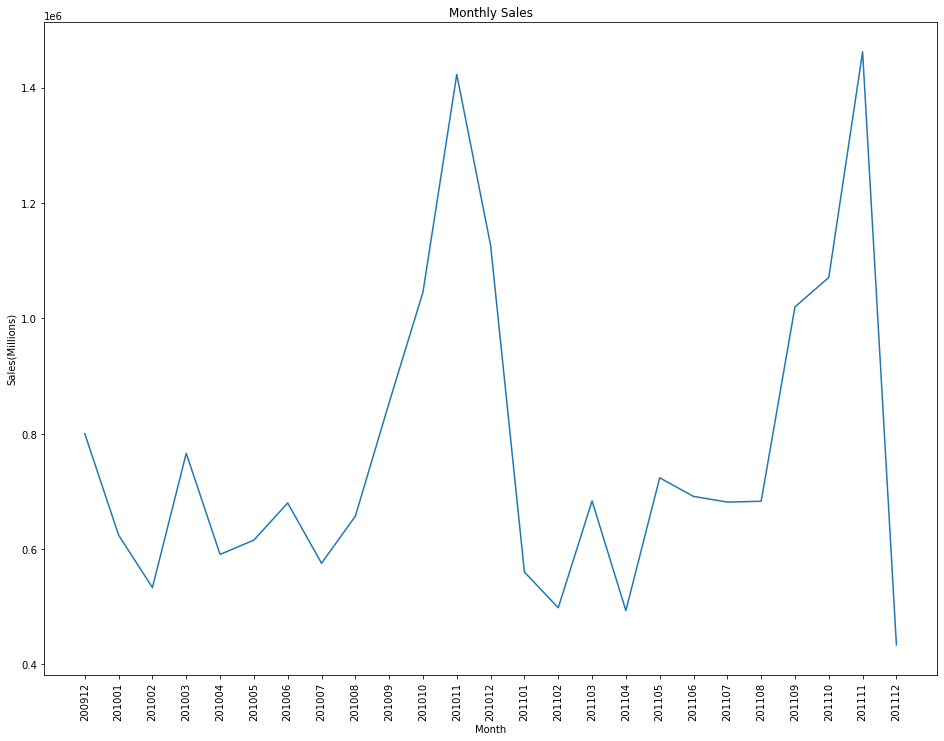

In [11]:
# Plot monthly sales
fig, ax = plt.subplots(figsize=(16,12))
ax.set_title('Monthly Sales')
ax.plot(sales_month.reset_index()['Month'], sales_month.Sales)
plt.xticks(rotation = 90)
plt.ylabel('Sales(Millions)')
plt.xlabel('Month')
plt.show()

# Monthly Sales Growth


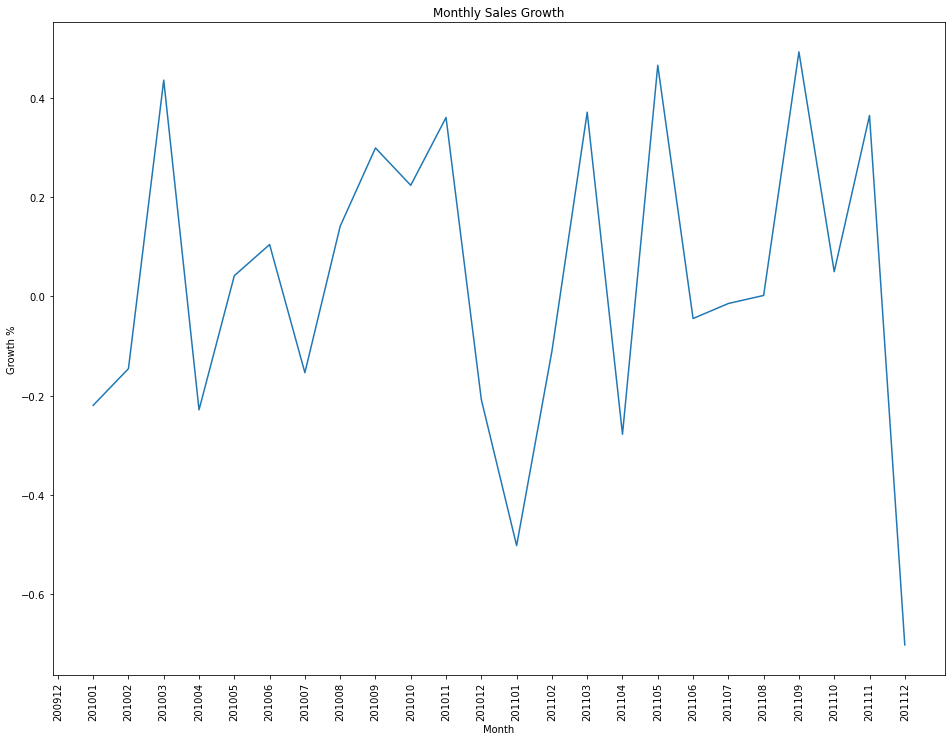

In [12]:
# use pct_change() to calculate difference from previous row
sales_month['Growth %'] = sales_month.Sales.pct_change()

fig, ax = plt.subplots(figsize=(16,12))
ax.set_title('Monthly Sales Growth')
ax.plot(sales_month.reset_index()['Month'], sales_month['Growth %'])
plt.xticks(rotation = 90)
plt.ylabel('Growth %')
plt.xlabel('Month')
plt.show()

# Monthly Active Users

     Month  customer_id
0   200912         1045
1   201001          786
2   201002          807
3   201003         1111
4   201004          998
5   201005         1062
6   201006         1095
7   201007          988
8   201008          964
9   201009         1202
10  201010         1577
11  201011         1683
12  201012          948
13  201101          783
14  201102          798
15  201103         1020
16  201104          899
17  201105         1079
18  201106         1051
19  201107          993
20  201108          980
21  201109         1302
22  201110         1425
23  201111         1711
24  201112          686


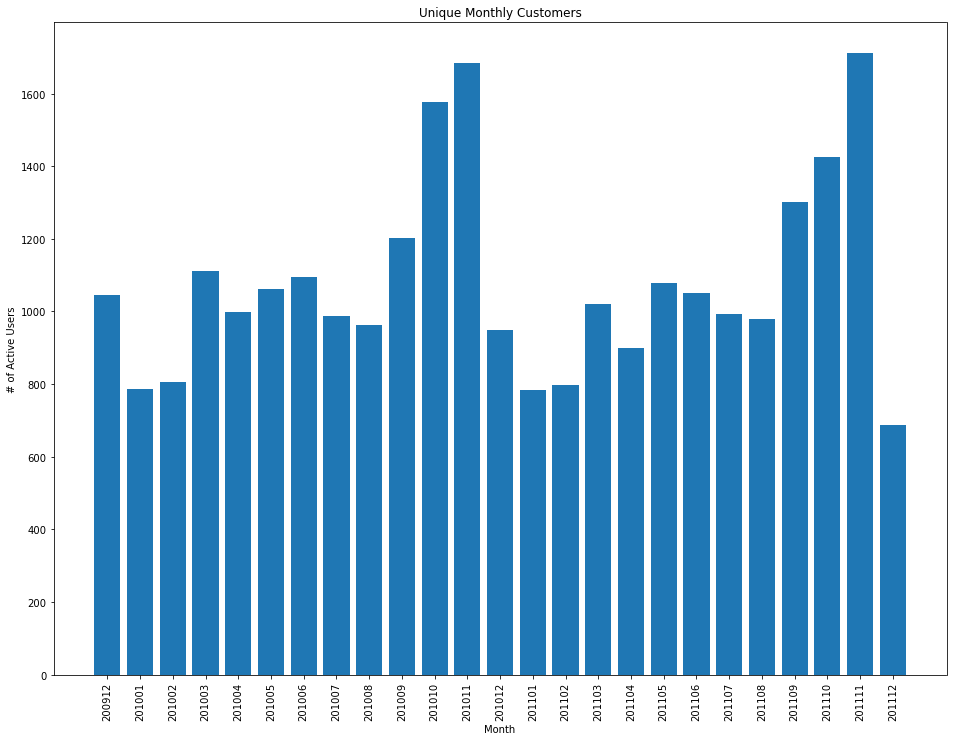

In [13]:

unique_monthly_customers = retail_df.groupby(by=['Month']).customer_id.nunique().reset_index()
print(unique_monthly_customers)

fig, ax = plt.subplots(figsize=(16,12))
ax.set_title('Unique Monthly Customers')
ax.bar(unique_monthly_customers.reset_index()['Month'], unique_monthly_customers.customer_id)
plt.xticks(rotation = 90)
plt.ylabel('# of Active Users')
plt.xlabel('Month')
plt.show()

# New and Existing Users



Text(0.5, 1.0, 'Monthly New and Existing Users')

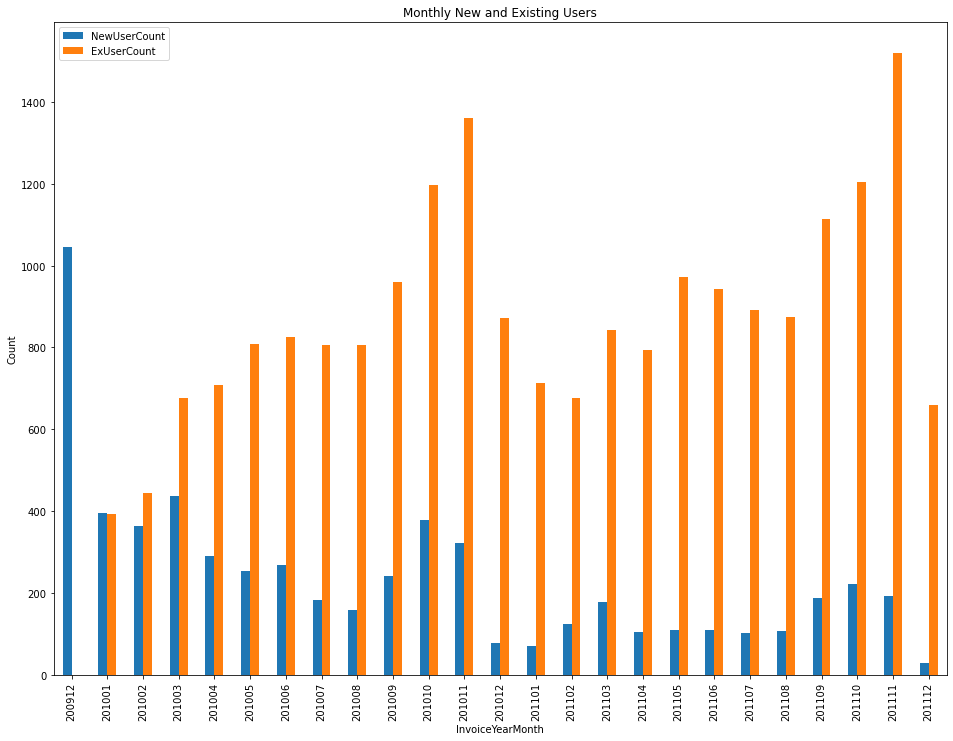

In [40]:
# check number of new customers each month using sort_values, then first()
new_monthly_customers = retail_df[['Month', 'customer_id']].copy().sort_values(by='Month')
user_count = new_monthly_customers.groupby("customer_id").first().reset_index().groupby(by='Month').count().reset_index()
df = user_count.rename(columns={"customer_id":"NewUserCount"})
#take overall customers, calculate existing by [total - new] each month
unique_monthly_customers = retail_df.groupby(by=['Month']).customer_id.nunique().reset_index()
unique_monthly_customers["NewUserCount"] = df["NewUserCount"]
unique_monthly_customers["ExUserCount"] = unique_monthly_customers.customer_id - unique_monthly_customers.NewUserCount

unique_monthly_customers.plot(x="Month", y=["NewUserCount", "ExUserCount"], kind='bar', figsize=(16,12))
plt.xlabel('InvoiceYearMonth')
plt.ylabel('Count')
plt.title('Monthly New and Existing Users')

## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

Optional Reading: [Making Your Database Pay Off Using Recency Frequency and Monetary Analysis](http://www.dbmarketing.com/2010/03/making-your-database-pay-off-using-recency-frequency-and-monetary-analysis/)


RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

Note: To simplify the problem, let's keep all placed and canceled orders.


**Sample RFM table**

![](https://i.imgur.com/sXFIg6u.jpg)

In [42]:
%store -r rfm_table
rfm_table

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346.0,77556.46,347,12.0,2,5,5,255,Can't Lose
12347.0,5633.32,24,8.0,5,4,5,545,Champions
12348.0,2019.40,97,5.0,3,4,4,344,Loyal Customers
12349.0,4428.69,40,4.0,5,3,5,535,Potential Loyalists
12350.0,334.40,332,1.0,2,1,2,212,Hibernating
...,...,...,...,...,...,...,...,...
18283.0,2736.65,25,22.0,5,5,4,554,Champions
18284.0,461.68,453,1.0,1,2,2,122,Hibernating
18285.0,427.00,682,1.0,1,2,2,122,Hibernating


In [44]:
%store -r segment_table
segment_table

Recency        Frequency            Monetary      
                           mean count       mean count          mean count
Segment                                                                   
About to Sleep       128.618557   388   1.360825   388    531.969905   388
At Risk              394.942667   750   3.904000   750   1383.596253   750
Can't Lose           352.802817    71  15.929577    71   8355.677634    71
Champions             30.250000   852  19.214789   852  10795.520581   852
Hibernating          481.012484  1522   1.252300  1522    437.963135  1522
Loyal Customers       89.306016  1147   9.802964  1147   4199.728592  1147
Need Attention       135.241636   269   3.156134   269   1283.114015   269
New Customers         32.303571    56   1.000000    56    356.257857    56
Potential Loyalists   47.297335   713   2.589060   713   1155.427281   713
Promising             60.281818   110   1.000000   110    324.497000   110